In [2]:
# Create reference images in EPSG:4326
!gdalwarp -of GTiff -t_srs EPSG:4326 -multi -wo NUM_THREADS=ALL_CPUS --config GDAL_CACHEMAX 16384 data/reference/ortofoto_reference_epsg32632.tif data/reference/ortofoto_reference_epsg4326.tif
!gdal_translate data/reference/ortofoto_reference_epsg4326.tif data/reference/ortofoto_reference_epsg4326_cog.tif -of COG -co COMPRESS=DEFLATE -co NUM_THREADS=ALL_CPUS -co BIGTIFF=YES --config GDAL_CACHEMAX 16384
!rm data/reference/ortofoto_reference_epsg4326.tif
!mv data/reference/ortofoto_reference_epsg4326_cog.tif data/reference/ortofoto_reference_epsg4326.tif

!gdalwarp -of GTiff -t_srs EPSG:4326 -multi -wo NUM_THREADS=ALL_CPUS --config GDAL_CACHEMAX 16384 data/reference/ortofoto_reference_epsg32632_nodata_mask.tif data/reference/ortofoto_reference_epsg4326_nodata_mask.tif
!gdal_translate data/reference/ortofoto_reference_epsg4326_nodata_mask.tif data/reference/ortofoto_reference_epsg4326_nodata_mask_cog.tif -of COG -co COMPRESS=DEFLATE -co NUM_THREADS=ALL_CPUS -co BIGTIFF=YES --config GDAL_CACHEMAX 16384
!rm data/reference/ortofoto_reference_epsg4326_nodata_mask.tif
!mv data/reference/ortofoto_reference_epsg4326_nodata_mask_cog.tif data/reference/ortofoto_reference_epsg4326_nodata_mask.tif

Using band 4 of source image as alpha.
Creating output file that is 41102P x 26320L.
Processing data/reference/ortofoto_reference_epsg32632.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...Input file size is 41102, 26320
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 41102P x 26320L.
Processing data/reference/ortofoto_reference_epsg32632_nodata_mask.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image data/reference/ortofoto_reference_epsg32632_nodata_mask.tif.
Copying nodata values from source data/reference/ortofoto_reference_epsg32632_nodata_mask.tif to destination data/reference/ortofoto_reference_epsg4326_nodata_mask.tif.
...10...20...30...40...50...60...70...80...90...Input file size is 41102, 26320
0...10...20...30...40...50...60...70...80...90...100 - done.


In [1]:
# Set the max. cache for gdal
!export GDAL_CACHEMAX=16384  # GDAL cache size in MB

In [8]:
# Find all the images to be co-registered
from pathlib import Path

target_file_names = list(Path('/workspace/output_dir').glob('*.tif'))
print(target_file_names)

[PosixPath('/workspace/output_dir/S1B_20170408_005065_DSC_139_RGB.tif'), PosixPath('/workspace/output_dir/S1A_20160724_012286_DSC_139_RGB.tif'), PosixPath('/workspace/output_dir/S1B_20201025_023965_DSC_139_RGB.tif')]


Co-registering /workspace/output_dir/S1B_20170408_005065_DSC_139_RGB.tif
Bounding box of calculated footprint for reference image:
	(7.991379004455191, 54.52612444878368, 13.062654135462305, 57.77355672575578)
Bounding box of calculated footprint for image to be shifted:
	(6.433345632955306, 53.30639650478044, 12.030029516076748, 58.1982622159817)
resolutions:  0.00012338268529529252 8.983152841195215e-05
47.90 percent of the image to be shifted is covered by the reference image.
Matching window position (X,Y): 9.2/56.1
Original matching windows:


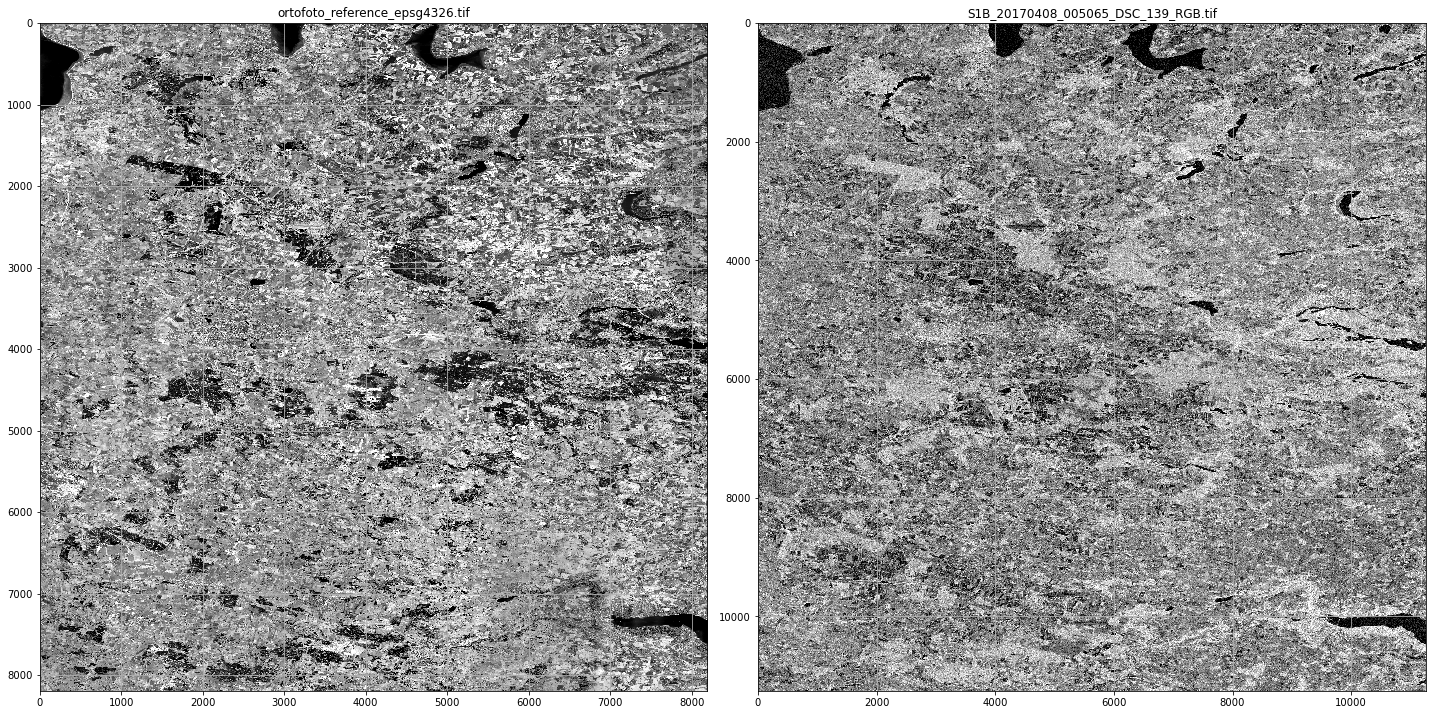

Matching windows with equalized spatial resolution:


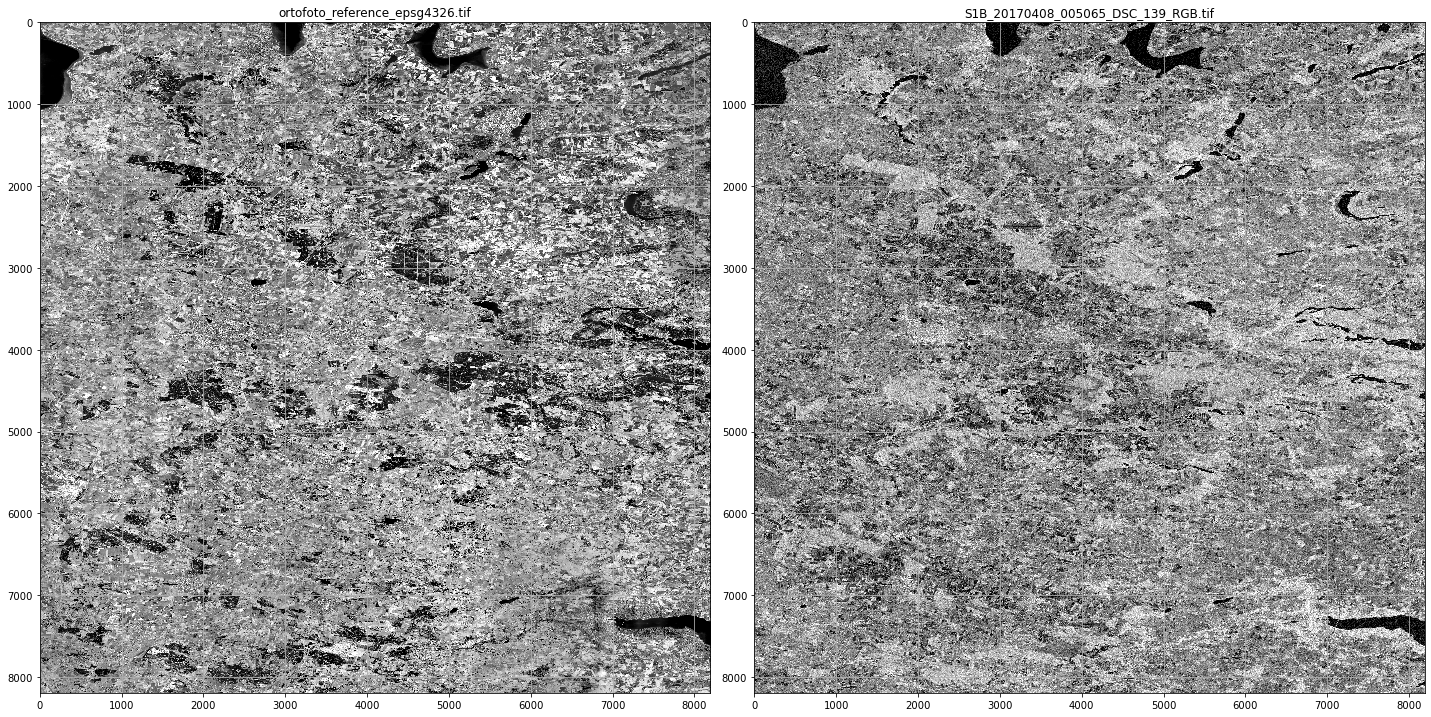

xgsd_factor 1.3734897699778685
ygsd_factor 1.3734897699778685
imfft_xgsd_mapvalues 0.00012338268529529252
imfft_ygsd_mapvalues 0.00012338268529529252
final window size: 8192/8192 (X/Y)


In [ ]:
from arosics import COREG
from pathlib import Path

im_targets = list(Path('/workspace/output_dir').glob('*.tif'))
for im_target in im_targets:
    print(f"Co-registering {im_target}")
    
    # Define the destination path of the image after correction
    dst_path = Path('/workspace') / 'output_dir_coreg' / (im_target.stem + '_coreg.tif')

    # Set the path of the reference image to use for correcting
    reference_im_path = Path('/workspace/mnt/app/data/reference')
    im_reference = str(reference_im_path / 'ortofoto_reference_epsg4326.tif')

    kwargs = {
    #     'mask_baddata_ref': str(reference_im_path / 'ortofoto_reference_epsg4326_nodata_mask.tif'),
        'path_out': str(dst_path),
        'fmt_out': 'COG',  # Output Cloud Optimized GeoTIFF (COG) format
        'out_crea_options': ['COMPRESS=DEFLATE', 'NUM_THREADS=ALL_CPUS'],  # Use DEFLATE compression for the output geotiff
        'wp': (9.20, 56.10),  # Use a manually chosen window position
        'ws': (8192, 8192),  # Use a manually chosen window size
        'nodata': (255., -32768),  # Input/output nodata values
        'calc_corners': False,  # We provided the window position and size manually, so no reason to calculate corners
        'q': False, 
        'v': True 
    }

    CR = COREG(str(im_reference), str(im_target), **kwargs)
    CR.calculate_spatial_shifts()
    CR.correct_shifts()
    print("Shift reliability is " + str(round(CR.shift_reliability, 2)) + "% for " + str(dst_path))